In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Vacation, all I ever wanted

- Choose start and end dates for the trip: should be 3-15 days
- May 15 - May 21

In [10]:
vac_start_date = '2017-05-15'
vac_end_date = '2012-05-21'

# Exploratory Climate Analysis

## Precipitation Analysis
- Design a query to retrieve the last 12 months of precipitation data and plot the results

In [11]:
# Determine the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [12]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [28]:
# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago).\
    order_by(Measurement.date).all()

In [29]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data, columns=['date', 'precipitation'])
prcp_df.head(10)

,date,precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22
5,2016-08-24,2.15
6,2016-08-24,1.45
7,2016-08-25,0.08
8,2016-08-25,0.08
9,2016-08-25,0.00


In [30]:
prcp_df['date']=pd.to_datetime(prcp_df['date'])

In [31]:
prcp_df.set_index('date', inplace=True)
prcp_df.head(10)

,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08


In [32]:
prcp_df.shape

(2223, 1)

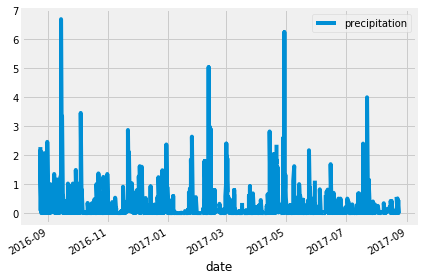

In [38]:
# Use Pandas Plotting with Matplotlib to plot the data
#prcp_df.plot.bar()
prcp_df.plot(use_index=True, y ='precipitation')
plt.tight_layout()
plt.show()

In [39]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [40]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count((Station.station).distinct())).all()

[(9)]

In [41]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Station.station, func.count(Measurement.station)).\
    filter(Station.station == Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [42]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = session.query(Station.station).\
    filter(Station.station == Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.station).desc()).first()

low_t = session.query(func.min(Measurement.tobs)).\
    filter(Station.station == 'USC00519281').all()
high_t = session.query(func.max(Measurement.tobs)).\
    filter(Station.station == 'USC00519281').all()
avg_t = session.query(func.avg(Measurement.tobs)).\
    filter(Station.station == 'USC00519281').all()

print(f"Lowest temperature recorded:{low_t}")
print(f"Highest temperature recorded:{high_t}")
print(f"Average temperature recorded:{avg_t}")

Lowest temperature recorded:[(53.0,)]
Highest temperature recorded:[(87.0,)]
Average temperature recorded:[(73.09795396419437,)]


In [43]:
# Choose the station with the highest number of temperature observations.
most_t_station = session.query(Station.station).\
    filter(Station.station == Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.tobs).desc()).first()
most_t_station

('USC00519281')

In [48]:
# Query the last 12 months of temperature observation data for this station 

temp_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > year_ago).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date).all()

temp_df = pd.DataFrame(temp_data, columns=['Date', 'Temperature Observed for Station: USC00519281'])
temp_df.set_index('Date', inplace=True)

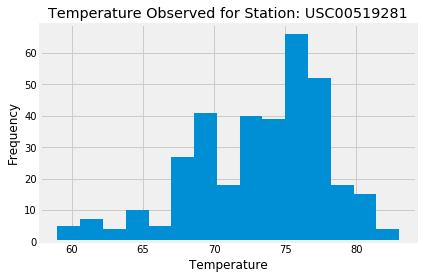

In [49]:
# Plot the results as a histogram
temp_df.hist(bins=15)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.show()

## Temperature Analysis (Optional)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-05-15', '2017-05-21'))

In [ ]:
t_avg = session.query(func.avg(Measurement.tobs)).\
        filter(Measurement.date >= '2017-05-15').filter(Measurement.date <= '2017-05-21').all()
t_min = session.query(func.min(Measurement.tobs)).\
        filter(Measurement.date >= '2017-05-15').filter(Measurement.date <= '2017-05-21').all()
t_max = session.query(func.max(Measurement.tobs)).\
        filter(Measurement.date >= '2017-05-15').filter(Measurement.date <= '2017-05-21').all()
peak_to_peak = t_max - t_min

In [ ]:
peak_to_peak

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
